# Data Mining Project
This notebook is the final project for data-mining course.
For this project we applied data-mining techniques with python's scikit-learn library.
The project consist:
1. **Data Exploration:**
    - statistics about the features
    - scatter plots for the features
    - correlation matrix
    - violinplot
2. **Feature Engineering:**
    - LDA
    - PCA
    - Modification for PCA
    - Feature Generation
3. **KNN**
    - Hyperparameter optimization
    - apply with different preprocessing
4. **Gaussian Naive Bayes**
    - apply with different preprocessing
5. **Multilayer Perceptron:**
    - apply with different preprocessing 
6. **Boosting:**
    - Based on decision trees
    - Based on Gaussian Naive Bayes
7. ** Evaluation**
    - Confusion matrix
    - Receiver operating characteristic (ROC)

## Imports

In [1]:
%matplotlib inline
# core
import numpy as np
import pandas as pd
import scipy.stats
# visualization
import matplotlib.pyplot as plt
import seaborn as sns  # seaborn is now installed by default. https://docs.anaconda.com/anaconda/release-notes#id10
from IPython.display import HTML, display
import matplotlib.patches as mpatches
# classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# etc.
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from scipy import interp
from sklearn.preprocessing import StandardScaler
import itertools

df = pd.read_csv("train.csv")
d = {}  # dictionary for the results of each model.
d_roc = {}

## Auxiliary Functions
The following functions will be called during the notebook.

In [2]:
def show_scatter(col, y, title):
    '''
    creates a scatter plot of the given column
    :param col: column - feature
    :param y: labels
    :param title: title for the plot
    :return: None, show visualization
    '''
    plt.scatter(col, lables2floats(y), c=lables2floats(y), s=30, cmap="bwr")
    plt.title(title)
    plt.xlabel('values')
    plt.scatter(col, [0.5] * len(col), c=lables2floats(y), s=500, alpha=0.05, cmap="bwr")
    plt.yticks([])
    plt.ylim(-0.05, 1.05)
    blue_patch = mpatches.Patch(color='blue', label='Class_2')
    red_patch = mpatches.Patch(color='red', label='Class_6')
    plt.legend(handles=[blue_patch, red_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [3]:
def standardize(X_train, X_validation):
    '''
    Standardize features by removing the mean and scaling to unit variance.
    :param X_train: feature df in the training set
    :param X_validation: feature df in the validation set
    :return: standardized training and validation sets
    '''
    scaler = StandardScaler()
    # fit only on training data
    scaler.fit(X_train)
    X_norm_train = scaler.transform(X_train)
    # apply same transformation to test data
    X_norm_validation = scaler.transform(X_validation)
    return X_norm_train, X_norm_validation

The following function adopted from example in scikit-learn's examples, it gives a good visualization of the confusion matrix

In [4]:
# Adopted from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(round(cm[i, j],2)),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [5]:
class DictTable(dict):
    def _repr_html_(self):
        '''
        gets a dictionary, sort it by values 
        :return: HTML for the table 
        '''
        html = ["<table><tr><td>Model</td><td>AUC</td></tr>"]
        for key, value in sorted(self.items(), key=lambda x: x[1], reverse=True):
            html.append("<tr>")
            html.append("<td>{0}</td>".format(key))
            html.append("<td>{0}</td>".format(value))
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

### evaluation function
Since we want to evalute all the models in consistent way and to reuse code we created the following function.
It does the following steps: 
- splits the data with kfold methods
- fits the classifier and calculates auc for every fold
- calculates the mean confusion matrix and auc
- plots the ROC curve and confusion matrix if needed 

In [6]:
def evaluate_auc_roc(X, y, clf, n_splits=5, plot=False, standardize_data=False, model_name=None):
    '''
    Evaluates a classifier using AUC and applies k-fold for cross validation. Plots ROC curve and confusion matrix.
    :param X: training set as df or np matrix
    :param y: labels for each row in the training set
    :param clf: a valid scikit-learn classifier
    :param n_splits: number of folds for the kfold
    :param plot: plot the data or return only auc
    :param standardize_data: should the data be standardized
    :return: returns AUC score for the given classifier.
    '''
    cnf = np.zeros((2, 2)) # null confusion matrix
    if isinstance(X, pd.DataFrame): # check if input is df and convert it to np matrix if needed
        X_np = X.as_matrix()
    else:
        X_np = X
    y_np = lables2floats(y) # convert labels from string to 0,1
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    kfold = KFold(n_splits, shuffle=False) 
    for train_index, validation_index in kfold.split(X_np):
        X_train, X_validation, y_train, y_validation = X_np[train_index], X_np[validation_index], y_np[train_index], \
                                                       y_np[validation_index]
        if standardize_data: # standardize data if needed
            X_train, X_validation = standardize(X_train, X_validation)
        probas_ = clf.fit(X_train, y_train).predict_proba(X_validation)
        fpr, tpr, thresholds = roc_curve(y_validation, probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        cnf += confusion_matrix(y_validation, clf.fit(X_train, y_train).predict(X_validation)) 
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    if plot: # plot ROC curve and confusion matrix if needed
        std_auc = np.std(aucs)
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random', alpha=.8)
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)
        if model_name is not None:
            d_roc[model_name] = mean_tpr
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        plot_confusion_matrix(cnf, classes=['class_6', 'class_2'], normalize=True)

    return mean_auc

## Preprocessing
Drop all records which doesn't belong to the 2 biggest classes

In [7]:
def find_largest_classes(df): 
    # return the name of the most commen targets
    df2=df.groupby("target").size()
    num_of_colms=list(df2.sort_values()[-2:].keys())
    return num_of_colms

def filter_classes(df):
    # return the data frame only with the common classes
    num_of_classes=find_largest_classes(df)
    print num_of_classes[0]
    df2=df[(df.target==num_of_classes[0]) | (df.target==num_of_classes[1])]
    return df2

def lables2floats(y):
    # maps: Class_2 => 0, Class_6 => 1 needed for colormaps which accept floats 
    d = {'Class_2':0.0,'Class_6':1.0}
    return np.array([d[i] for i in y])

In [8]:
filtered_data = filter_classes(df)
data = filtered_data
grouped = data.groupby('target')
X,y = data[data.columns[:-1]],data[data.columns[-1]]

Class_6


## data visualization
### statistics
The following table shows some statistics about all the features, grouped by the classes they belong.The table gives us a general intuition about the distribution of the features. For example, if we compare the max values of each feature we can get a general idea of a limit which divides the data into those two classes.

In [9]:
grouped.describe(include = 'all')

feat_12       feat_20       feat_21       feat_23  \
target                                                                  
Class_2 count  12059.000000  12059.000000  12059.000000  12059.000000   
        mean       0.091716      0.126710      0.169085      0.028609   
        std        0.337387      0.466171      0.569606      0.238716   
        min        0.000000      0.000000      0.000000      0.000000   
        25%        0.000000      0.000000      0.000000      0.000000   
        50%        0.000000      0.000000      0.000000      0.000000   
        75%        0.000000      0.000000      0.000000      0.000000   
        max        5.000000      9.000000      8.000000      6.000000   
Class_6 count  10660.000000  10660.000000  10660.000000  10660.000000   
        mean       0.171482      0.345497      0.461069      0.137711   
        std        0.540553      0.904406      1.074871      0.627559   
        min        0.000000      0.000000      0.000000      0.000000   
        25%        0.000000      0.000000      0.000000      0.000000   
        50%        0.000000      0.000000      0.000000      0.000000   
        75%        0.000000      0.000000      0.000000      0.000000   
        max       12.000000     13.000000     13.000000     15.000000   

                    feat_51       feat_56       feat_61       feat_69  \
target                                                                  
Class_2 count  12059.000000  12059.000000  12059.000000  12059.000000   
        mean       0.002239      0.118915      0.012190      0.056555   
        std        0.059675      0.933050      0.131089      0.363064   
        min        0.000000      0.000000      0.000000      0.000000   
        25%        0.000000      0.000000      0.000000      0.000000   
        50%        0.000000      0.000000      0.000000      0.000000   
        75%        0.000000      0.000000      0.000000      0.000000   
        max        3.000000     42.000000      3.000000     17.000000   
Class_6 count  10660.000000  10660.000000  10660.000000  10660.000000   
        mean       0.122420      0.243152      0.956473      0.183583   
        std        0.848570      0.740943      1.884253      0.771583   
        min        0.000000      0.000000      0.000000      0.000000   
        25%        0.000000      0.000000      0.000000      0.000000   
        50%        0.000000      0.000000      0.000000      0.000000   
        75%        0.000000      0.000000      1.000000      0.000000   
        max       44.000000     20.000000     33.000000     21.000000   

                     feat_7       feat_70  
target                                     
Class_2 count  12059.000000  12059.000000  
        mean       0.020483      0.762584  
        std        0.177976      1.719298  
        min        0.000000      0.000000  
        25%        0.000000      0.000000  
        50%        0.000000      0.000000  
        75%        0.000000      1.000000  
        max        9.000000     32.000000  
Class_6 count  10660.000000  10660.000000  
        mean       0.114728      0.584240  
        std        0.448145      1.358014  
        min        0.000000      0.000000  
        25%        0.000000      0.000000  
        50%        0.000000      0.000000  
        75%        0.000000      1.000000  
        max        9.000000     25.000000

### scatter of features

To visualize the scatter of the features we created the following plot.
This plot represents 2 characteristics of each feature simultaneously:
1. Class - by it's color
2. Density - the more transparent the less samples taken from this region. the small dots helps to see the transparent samples.
These characteristics helps to find Regions Of Interest (ROI), the purer - the better!

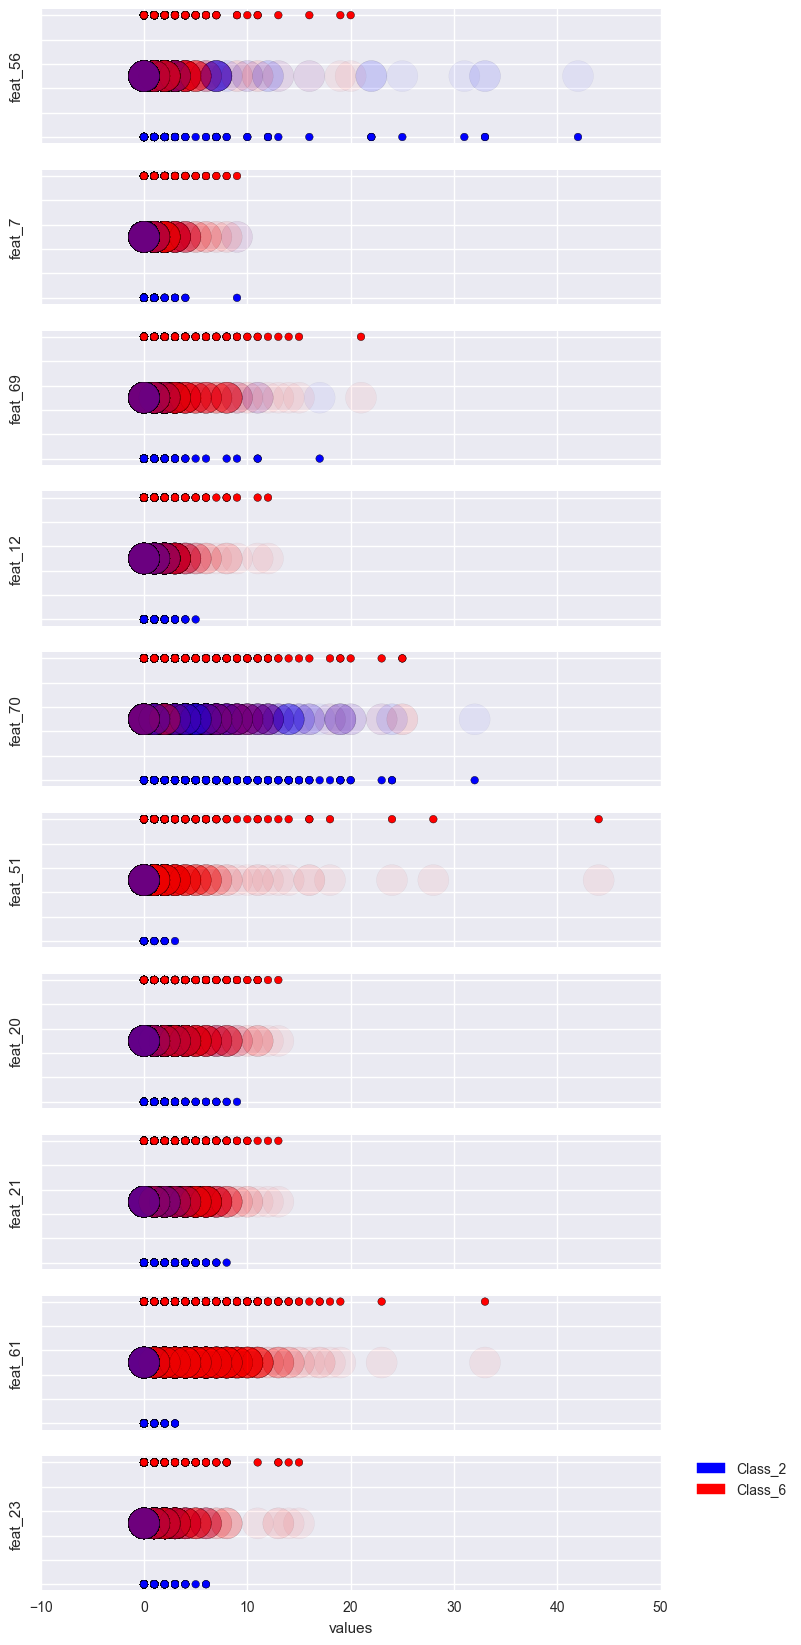

In [10]:
f, axarr = plt.subplots(10, sharex=True) 
tmp = 0
for feature in X:
    axarr[tmp].scatter(data[feature], lables2floats(y), c=lables2floats(y), s=30, cmap = "bwr")
    axarr[tmp].scatter(data[feature],[0.5]*len(data),c = lables2floats(y),s=500,alpha=0.05, cmap = "bwr")
    axarr[tmp].set_yticklabels([]) # clear y-axis because it meanningless 
    axarr[tmp].set_ylabel(feature) # set y-label to relevant feature
    axarr[tmp].set_ylim(-0.05, 1.05) # to place the small dots near the border 
    tmp+=1
    
plt.xlabel('values')
blue_patch = mpatches.Patch(color='blue', label='Class_2')
red_patch = mpatches.Patch(color='red', label='Class_6')
plt.legend(handles=[blue_patch, red_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.subplots_adjust(top = 3)
plt.show()

### correlation of features
#### correlation matrix
The following code plots a correlation matrix between all of the features. As the correlation value between two features gets higher it's background color will get darker.

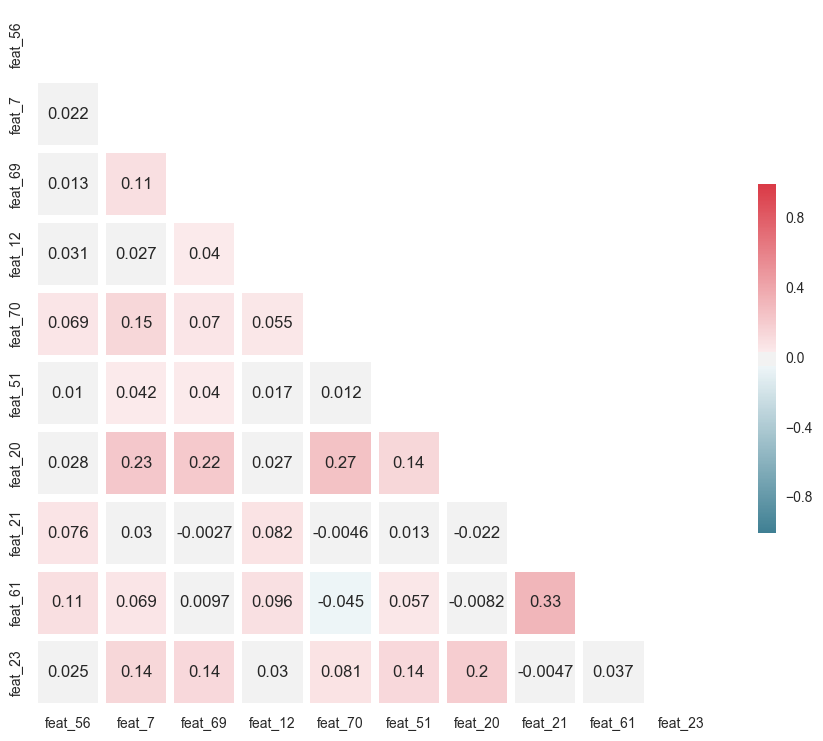

In [11]:
sns.set(style="white")
corr = X.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,annot=True, linewidths=5, cbar_kws={"shrink": 0.5})

#### violinplot
For better understanding of the correlation we are using violinplot. At first it may look confusing but this plot contain a lot of information about the relation between different features.The dot in the heart of the violin is the mean correlation of the given feature.Axis x represents the features so each violin refer to one feature, axis y represents the correlation range.The width of each violin represents the **distribution of correlations**.This draw helps us understand better the connections between the features.

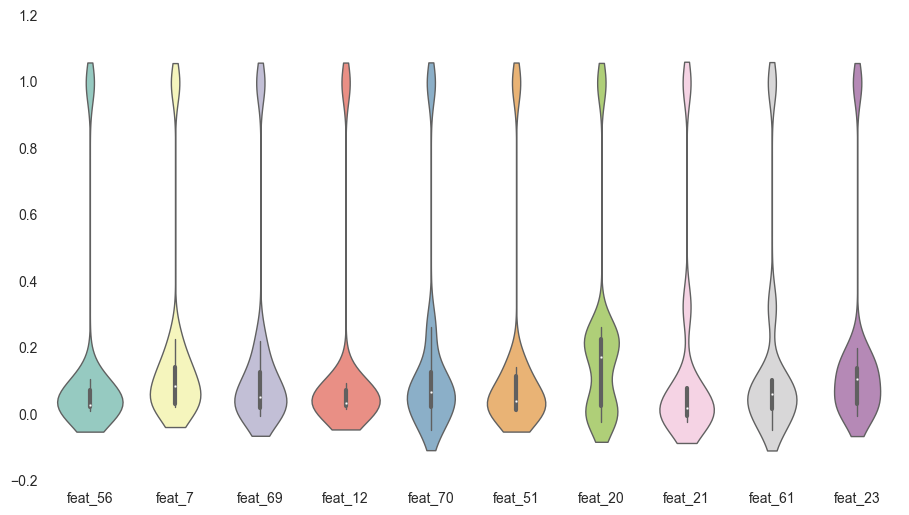

In [12]:
 
sns.set(style="white")
corr = X.corr()
corr_df = X.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=corr_df, palette="Set3", bw=.2, cut=1, linewidth=1)

# Finalize the figure
sns.despine(left=True, bottom=True)

## Feature generation

We wish to use our insights on the features to engineer a powerful feature. 
We will use PCA and LDA later, so now we will focus on nonlinear combinations of features that cannot be generated with these methods.
Our scatter plots reveals that feature 51 and 61 have potential to be powerful together because they both have many dense "blue" points near zero, bounded on 3 and have relatively small correlation. So taking the maximum looks promising. 

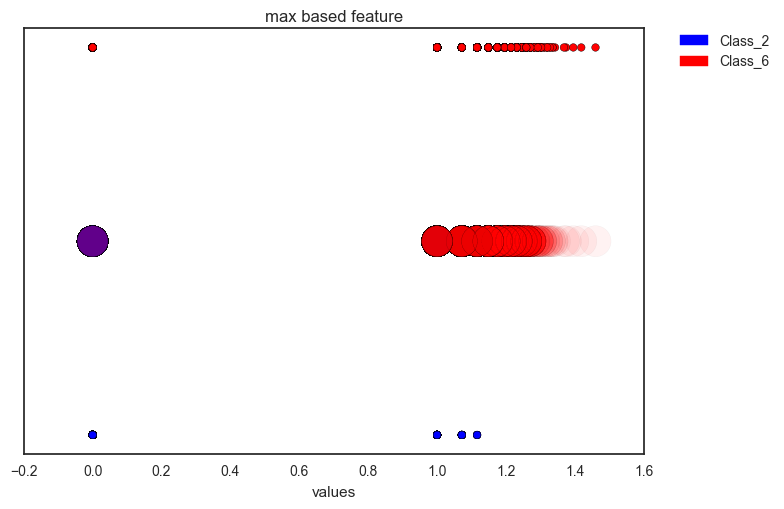

In [13]:
max_col = data[["feat_51", "feat_61"]].max(axis=1)**0.1
show_scatter(max_col,y,"max based feature")

To evaluate our feature we will use "round" as a classifier and draw the confusion matrix:

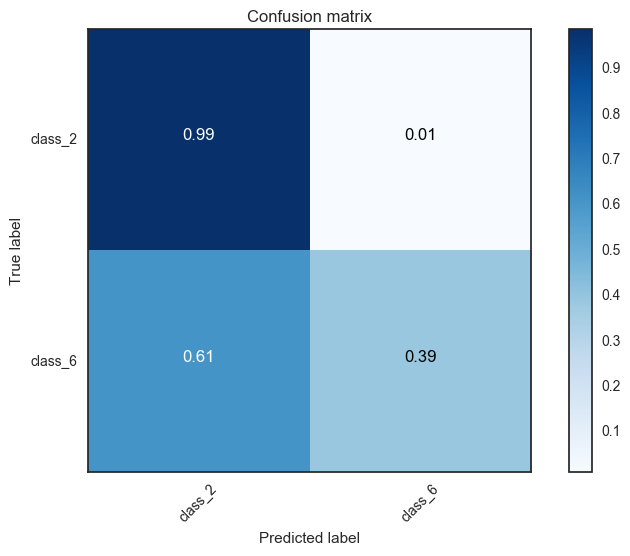

In [14]:
plot_confusion_matrix(confusion_matrix(lables2floats(y),np.round(max_col)), classes=['class_2','class_6'],normalize=True)

## Dimensionally Reduction
### LDA

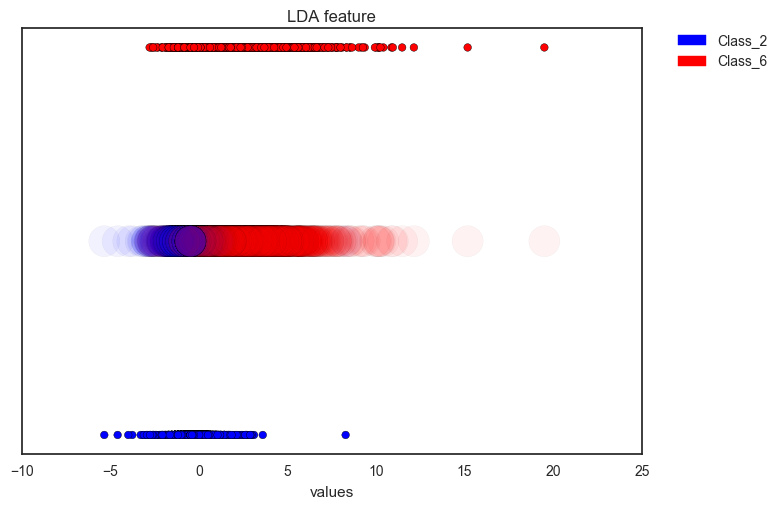

In [15]:
LDA = LinearDiscriminantAnalysis(n_components=2)
LDA.fit(X, y)
reduced_data = LDA.transform(X)
show_scatter(reduced_data[:, :],y,"LDA feature")

### PCA

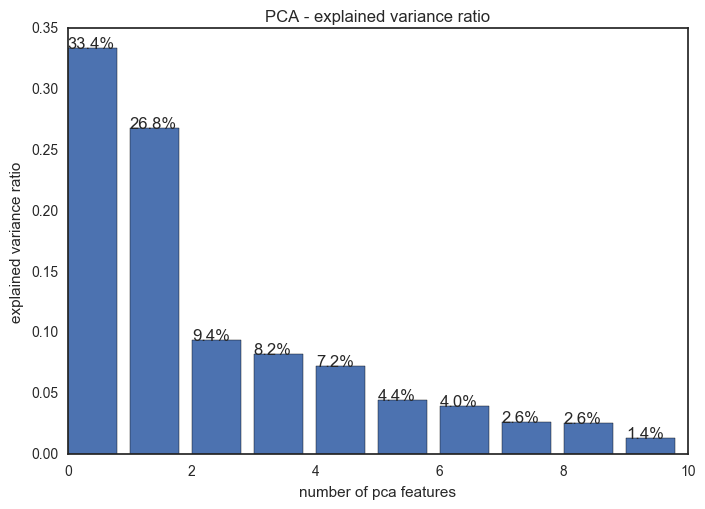

In [16]:
pca = PCA(n_components=10)
X_r = pca.fit(X).transform(X)
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
for a, b in zip(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_):
    plt.text(a, b, str(np.round(b, 3) * 100) + "%")
plt.title("PCA - explained variance ratio")
plt.ylabel('explained variance ratio')
plt.xlabel('number of pca features')
plt.show()

In [17]:
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

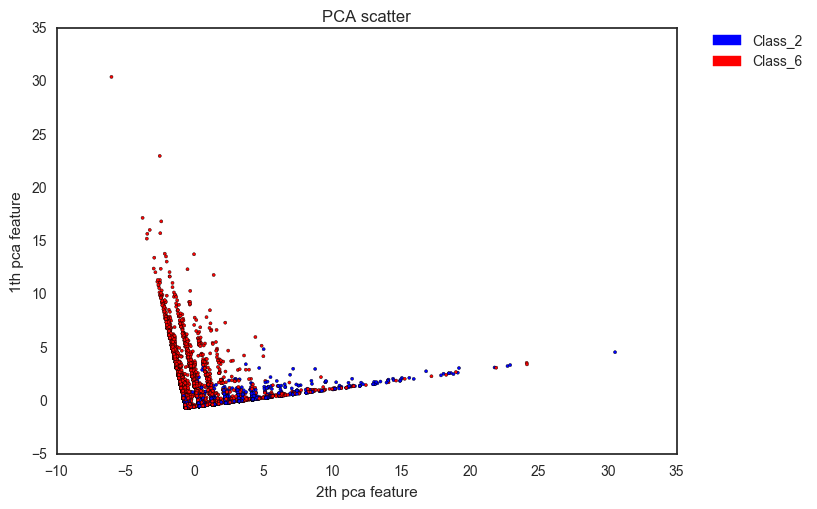

In [18]:
plt.scatter(X_r[:,0], X_r[:,1], s= 5, c=lables2floats(y), cmap = "bwr")
plt.title("PCA scatter")
plt.ylabel('1th pca feature')
plt.xlabel('2th pca feature')
blue_patch = mpatches.Patch(color='blue', label='Class_2')
red_patch = mpatches.Patch(color='red', label='Class_6')
plt.legend(handles=[blue_patch, red_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#### PCA after rotation
The structure of the PCA looks intresting, resambling some kind of a barplot..
However unfortunatly some models won't be able to detect and take adventage of this pattern.
We will assume Rotational invariance and rotate the data:

In [19]:
theta = np.radians(11)
c, s = np.cos(theta), np.sin(theta)
R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
X_r2 = np.array(X_r * R)

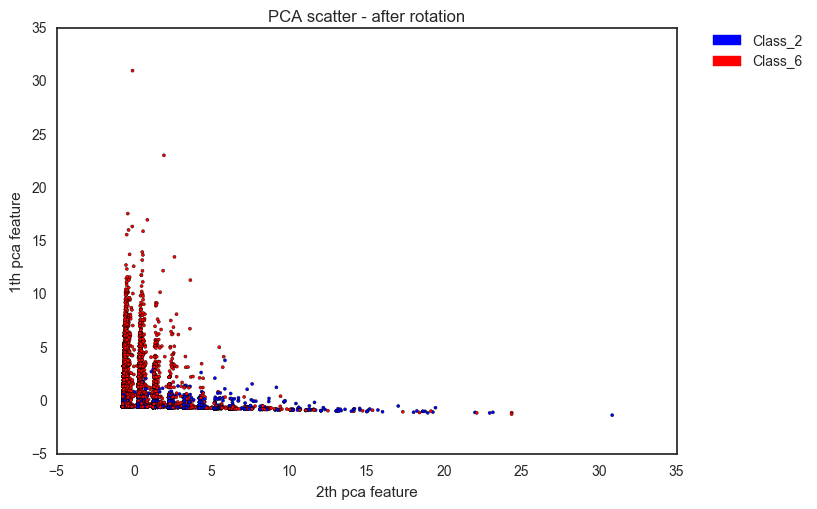

In [20]:
plt.scatter(X_r2[:,0], X_r2[:,1], s= 5, c=lables2floats(y), cmap = "bwr")
plt.title("PCA scatter - after rotation")
plt.ylabel('1th pca feature')
plt.xlabel('2th pca feature')
blue_patch = mpatches.Patch(color='blue', label='Class_2')
red_patch = mpatches.Patch(color='red', label='Class_6')
plt.legend(handles=[blue_patch, red_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

We would like to check the impact of the rotation.
In order to do so we will check different distance functions (euclidean,manhattan,chebyshev) before and after the rotation:

In [21]:

distances = ["euclidean","manhattan","chebyshev"]
distances_d = {}
for distance in distances:
    clf=KNeighborsClassifier(n_neighbors=5, metric=distance)
    distances_d["regular PCA " + distance] = evaluate_auc_roc(X_r,y,clf)
    distances_d["rotated PCA "+ distance] = evaluate_auc_roc(X_r2,y,clf)
DictTable(distances_d)

Model,AUC
rotated PCA euclidean,0.732279744464
rotated PCA manhattan,0.731762635815
rotated PCA chebyshev,0.731525348221
regular PCA euclidean,0.726800523219
regular PCA manhattan,0.726584493057
regular PCA chebyshev,0.726048363906


**Note that the "rotated" models got better AUC in all distances!**

## Trainning sets
At this section we will generate a list of different training sets from the last part:

In [22]:
combination_lst=[]
combination_lst_names=[]

In the next block we will add the training data as a benchmark for all engineered trainning sets. 

In [23]:
combination_lst_names.append("All training data")
combination_lst.append(X)

 We know that the performance of Naive Bayes can degrade if the data contains highly correlated features.
 In the next block we will remove the most correlated feature. 

In [24]:
combination_lst_names.append("training data without the most correlated column")
x_without_cor = X.drop(X.columns[np.array(X.corr().abs().sum()).argmax()],1)
combination_lst.append(x_without_cor)

Next we will enrich the original training set with two different strong features, the LDA and our "max column" feature.
We chose to do it because they both are very dense around zero, so they weak in that domain. Adding more dimensions may help.  

In [25]:
combination_lst_names.append("All training data with max-col feature")
all_with_maxcol = X.assign(e=max_col).values
combination_lst.append(all_with_maxcol)

combination_lst_names.append("All training data with LDA feature")
all_with_LDA = X.assign(e=reduced_data).values
combination_lst.append(all_with_LDA)

## K-Nearest Neighbour 
To get the most from knn we will search along two dimensions: training sets and the number of neighbours.
We will iterate through training sets, for each training set we will find the optimal k and than choose the model with the best auc.

In [26]:
def find_optimal_k(relevent_X, plot=False):
    '''
    optimize k for knn
    :param relevent_X: the training set 
    :param plot: should be plotted?
    :return: auc and optimal k
    '''
    # creating odd list of K for KNN
    neighbors = list(range(1, 15, 2))  # subsetting just the odd ones

    # empty list that will hold cv scores
    cv_auc = []

    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, metric="euclidean")  # calculate knn for k neighbors
        cv_auc.append(evaluate_auc_roc(relevent_X, y, knn))  # append to the list of auc
    # changing to misclassification error
    # determining best k
    optimal_k = neighbors[cv_auc.index(max(cv_auc))]
    # from sklearn import neighbors, datasets
    clf = KNeighborsClassifier(n_neighbors=optimal_k,
                               weights="uniform",
                               metric="euclidean",
                               algorithm="brute")
    clf.fit(relevent_X, y)
    if plot:
        plt.plot(neighbors, cv_auc, linestyle='--', marker='o')
        plt.title('auc as a function of k')
        plt.xlabel('Number of Neighbors K')
        plt.ylabel('Auc')
        plt.show()
        print
        "The optimal number of neighbors is %d" % optimal_k
        return
    return evaluate_auc_roc(relevent_X, y, clf), optimal_k

In [27]:
def find_best_combination(combination_lst):
    '''
    finds the best training set for knn
    :param combination_lst: list of training sets
    :return: index of best training set, list of auc, list of optimal k 
    '''
    max_index = 0
    n = len(combination_lst)
    auc_lst = []
    k_optimal_lst = []
    for i in range(n):
        clf = find_optimal_k(combination_lst[i])
        auc_lst.append(clf[0])
        k_optimal_lst.append(clf[1])
    return np.array(auc_lst).argmax(), auc_lst, k_optimal_lst

We get the maximun AUC when we use knn with All training data with LDA feature as training set. The score that we get in that case is 0.771593201492


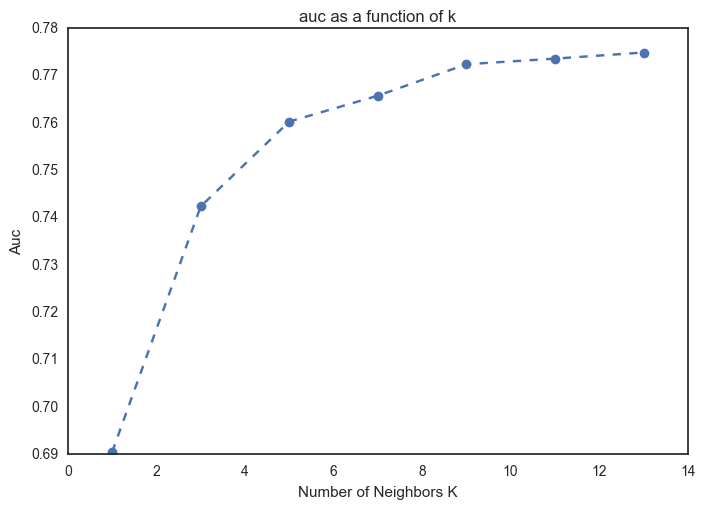

In [28]:
max_index,auc_lst,k_optimal_lst= find_best_combination(combination_lst)
knn_d = {}
for i in range(len(auc_lst)):
    knn_d[combination_lst_names[i]] = auc_lst[i]
print "We get the maximun AUC when we use knn with "+combination_lst_names[max_index] + " as training set. The score that we get in that case is "+ str(auc_lst[max_index])
find_optimal_k(combination_lst[max_index],plot=True)

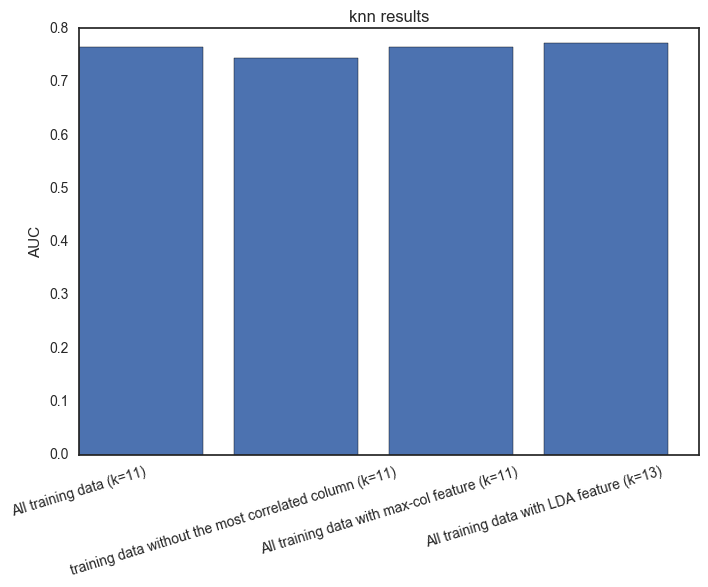

In [29]:
x = np.arange(len(combination_lst_names))
plt.bar(x,auc_lst)
plt.xticks(x,[combination_lst_names[i]+" (k="+str(k_optimal_lst[i])+")" for i in range(len(combination_lst_names))],rotation=17)
plt.title("knn results")
plt.ylabel('AUC')
plt.show()

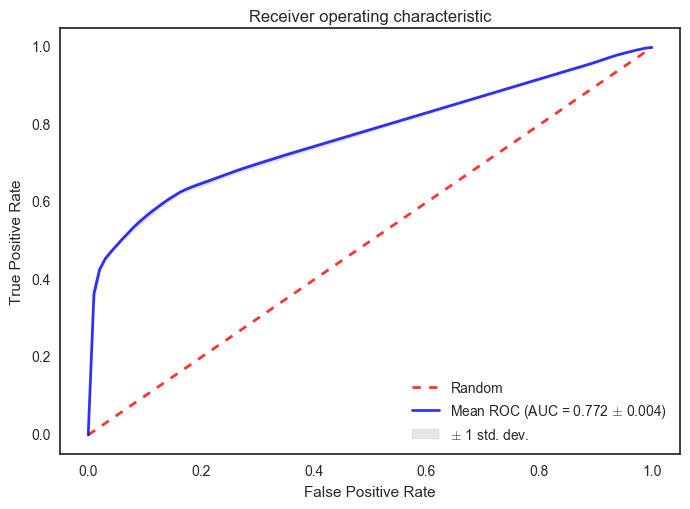

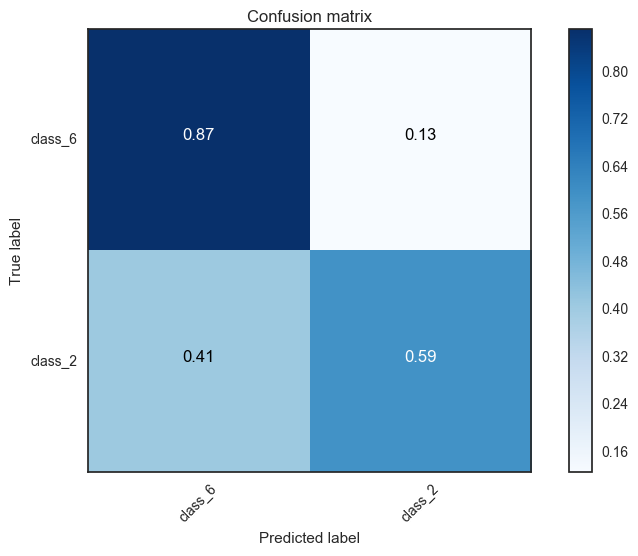

In [30]:
clf = KNeighborsClassifier(n_neighbors=k_optimal_lst[max_index], 
                           weights="uniform",
                           metric="euclidean",
                           algorithm= "brute")
d["KNN"] = evaluate_auc_roc(combination_lst[max_index],y,clf,plot=True,model_name="KNN")

## Gaussian Naive Bayes

In [31]:
clf = GaussianNB()
Naive_auc = [evaluate_auc_roc(comb,y,clf,n_splits=5) for comb in combination_lst]

All training data has the highest AUC: 0.763251358373


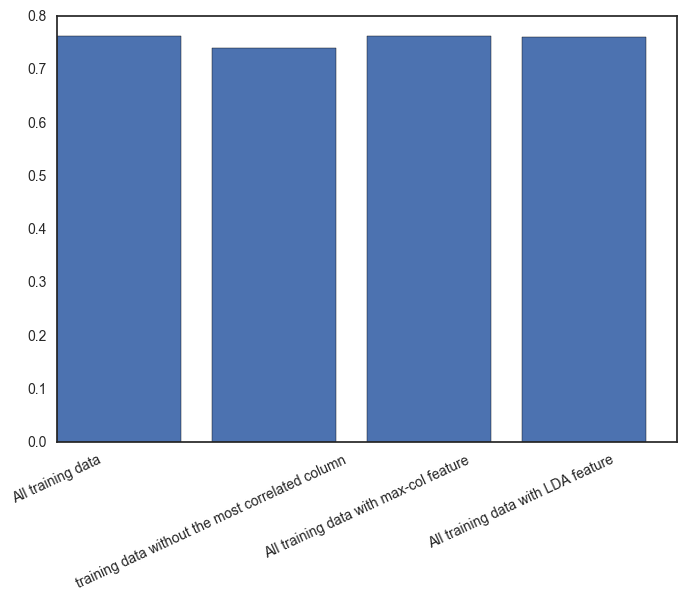

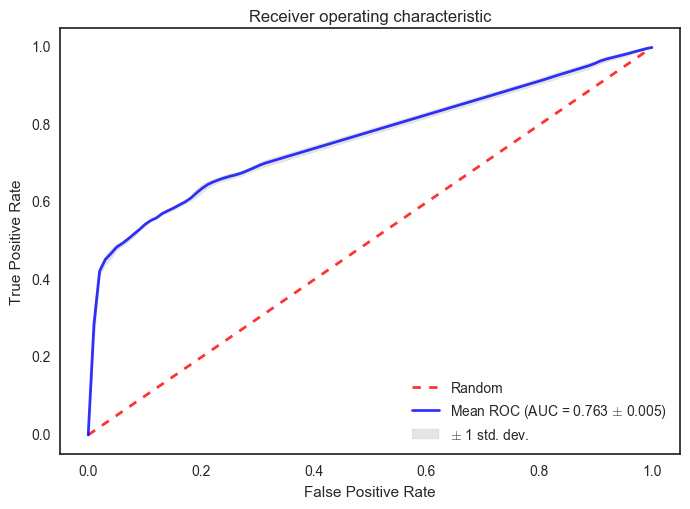

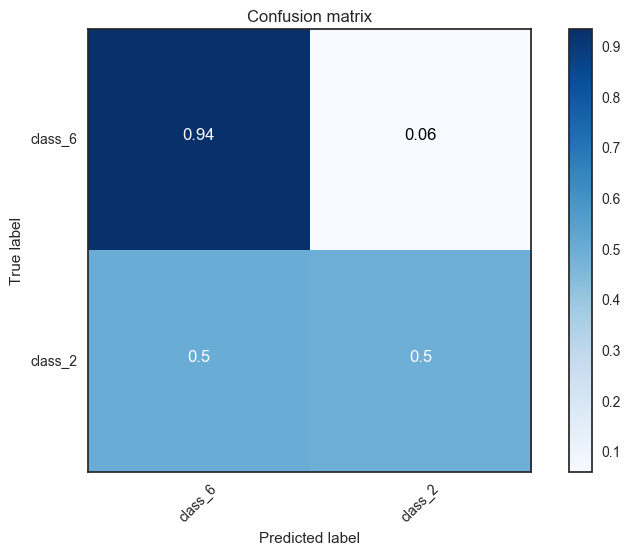

In [32]:
print(str(combination_lst_names[np.array(Naive_auc).argmax()])+" has the highest AUC: "+str(max(Naive_auc)))
x = np.arange(len(combination_lst_names))
plt.bar(x, Naive_auc) 
plt.xticks(x, combination_lst_names,rotation=25)
plt.show()
d["Gaussian Naive Bayes"] = evaluate_auc_roc(combination_lst[np.array(Naive_auc).argmax()],y,clf,n_splits=5,plot=True, model_name="Gaussian Naive Bayes")

## Multilayer Perceptron

In [33]:
clf = MLPClassifier(#-----The architecture:------#
                    activation="tanh", #What is the activation function between neurons {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}?
                    hidden_layer_sizes= (50,100,20),  #What is the architecture? what happens if we add more layers?
                    alpha = 0.00001, #The regularization: loss + alpha*W^2
                    batch_size = "auto",#when set to auto,batch zise= min(200,n_samples)
                    #-----The optimizer:------#
                    solver = "sgd", #Stochastic Gradient Descent, other optimizers are out of the scope of the course.
                    learning_rate = "adaptive", #How does the learning rate update itself? {‘constant’, ‘invscaling’, ‘adaptive’}
                    learning_rate_init = 0.5, #What is the initial learning rate? in some optimizers the learning rate changes.
                    power_t = 0.5, #When we choose learning rate to be invscaling, it means that we multiply this number each epoch.
                    momentum = 0.9, #Whats the fraction of the updated dedicated to the momentum? the "friction".
                    nesterovs_momentum = False, #Out of the scope of the course, leave false.
                    early_stopping = False, #Do we set a validation data aside?
                    tol = 1e-4, #A broad concept of converges, when we can say the algorithm converged?
                    warm_start = False, #if we fit at the second time, do we start from the last fit?
                    max_iter = 10000)


*Note that warm_start must be false, since we don't want to cheat with the kfold*

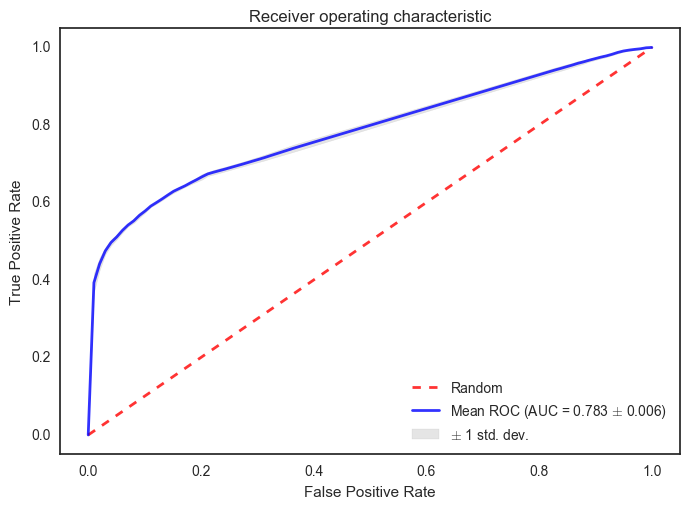

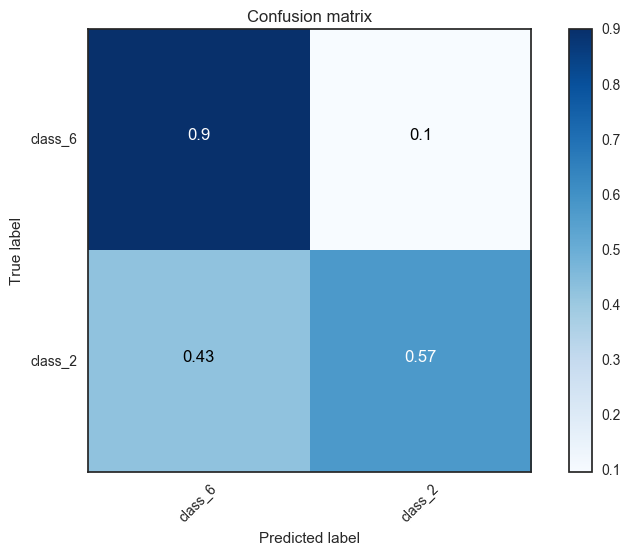

In [34]:
d["MLP"] = evaluate_auc_roc(X,y,clf,n_splits=5,plot=True, model_name="MLP")

#### Normlize Features
As we learnt in the lecture normalizing the inputs may improve it's performance  

C:\Users\Edan\Anaconda2\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


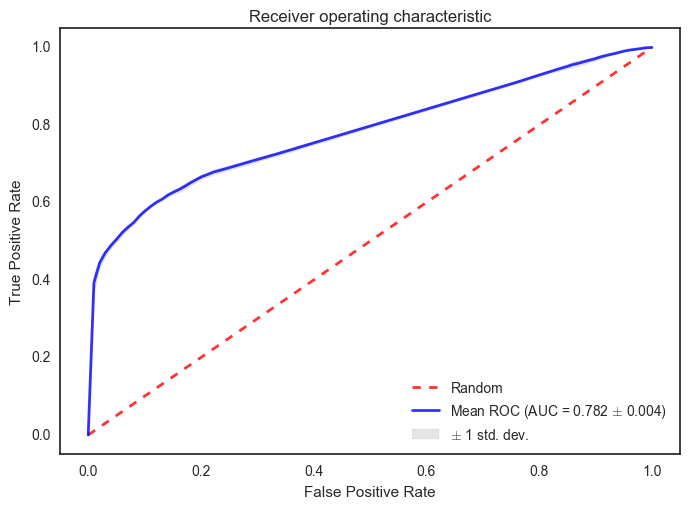

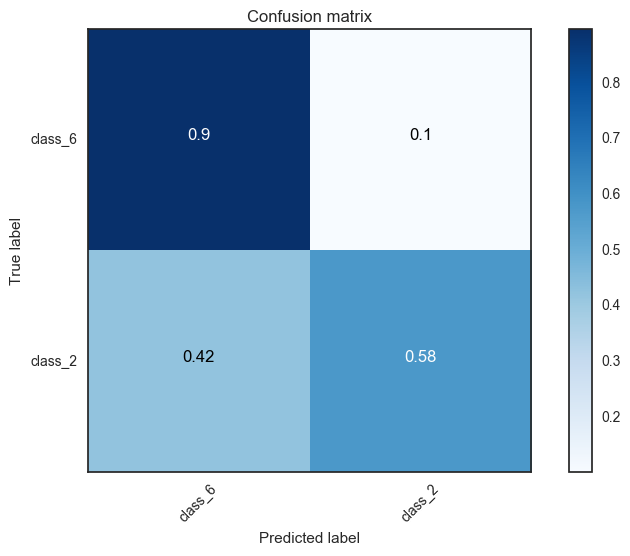

In [35]:
d["Normlized MLP"] = evaluate_auc_roc(X,y,clf,n_splits=5,plot=True,standardize_data=True, model_name="Normlized MLP")

### Random Forest Classifier
#### Based on decision trees

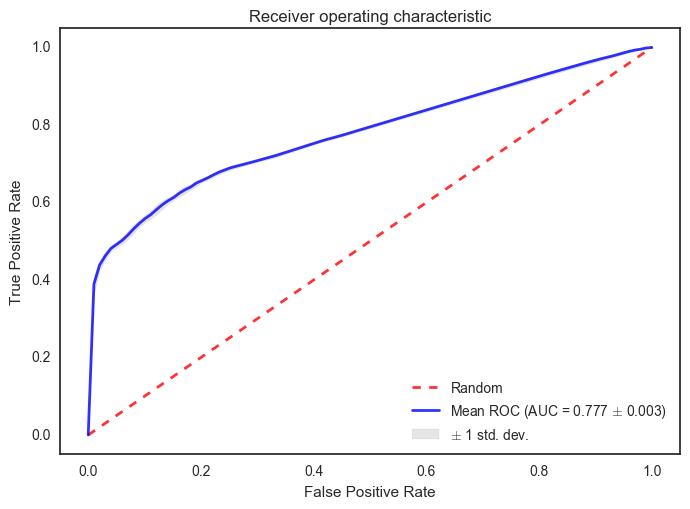

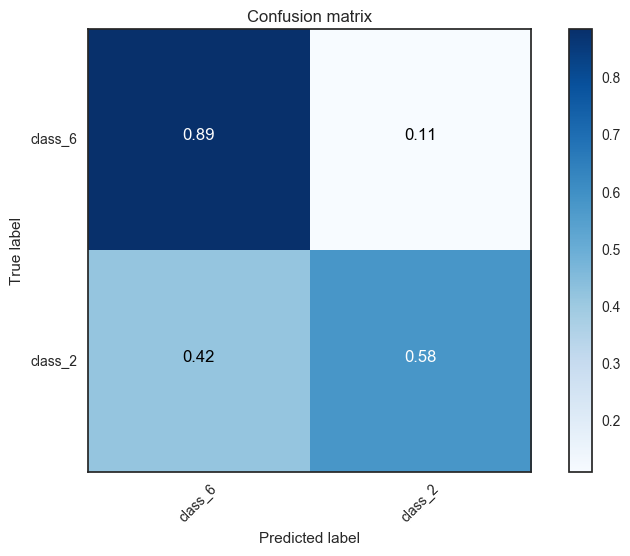

In [36]:
bdt_dt = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(min_samples_split=5,max_depth=5), n_estimators=364,algorithm = "SAMME") # 
d["Boosting Decision Trees"] = evaluate_auc_roc(X,y,bdt_dt,n_splits=5,plot=True, model_name="Boosting Decision Trees")

#### Based on Gaussian Naive Bayes

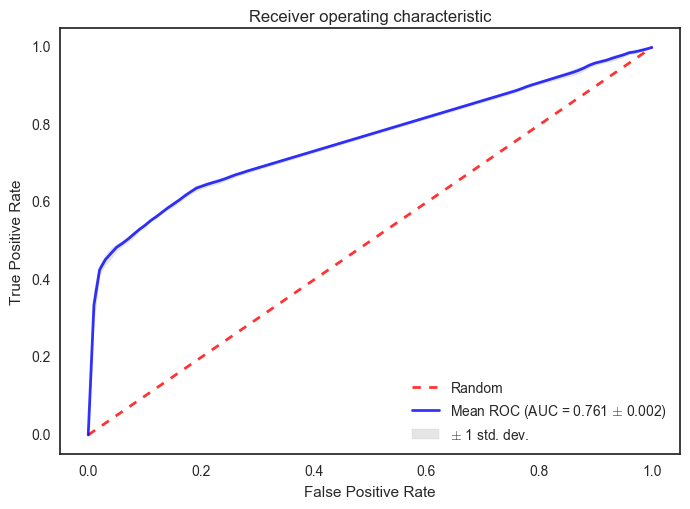

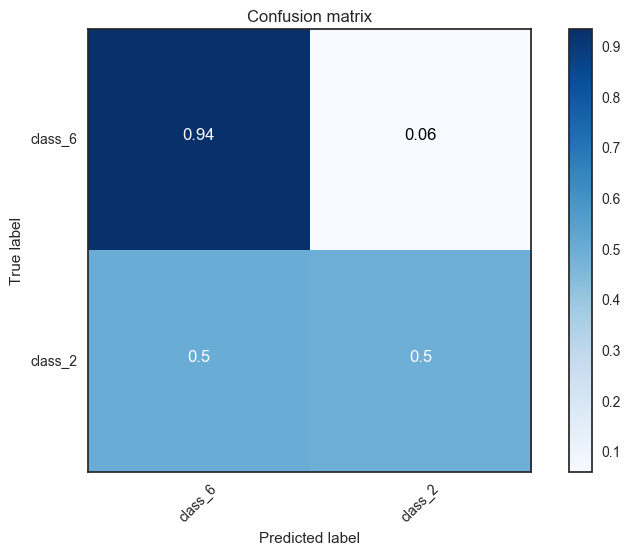

In [37]:
bdt_gnb = AdaBoostClassifier(base_estimator= GaussianNB(), n_estimators=364,algorithm = "SAMME")
d["Boosting Gaussian Naive Bayes"] = evaluate_auc_roc(X,y,bdt_gnb,n_splits=5,plot=True, model_name="Boosting Gaussian Naive Bayes")

Lets visualize that classifier with pca and rotated pca and check the results.

In [38]:
def plot_decision_bounderies(stage,X_r):
    plot_step = 0.1
    bdt = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(min_samples_split=5,max_depth=5), n_estimators=1000,algorithm = "SAMME") # 
    bdt.fit(X_r, lables2floats(y)) # split to train/test?!
    print("AUC: "+str(evaluate_auc_roc(pd.DataFrame(X_r),y,bdt_gnb,n_splits=5,plot=False)))
    plt.figure(figsize=(10, 10))
    
    x_min, x_max = X_r[:, 0].min() - 1, X_r[:, 0].max() + 1
    y_min, y_max = X_r[:, 1].min() - 1, X_r[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    
    # If we don't give a stage parameter, the computer will plot the decision boundaries of the ensemble.
    if stage==None:
        Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])


    #Given a specific stage, the decision boundaries that will be shown are the boundaries of the estimatior No. stage.
    else:
        Z= bdt.estimators_[stage].predict(np.c_[xx.ravel(), yy.ravel()])
        
    Z =Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z,cmap="seismic") #Plotting the decision boundaries of the base estimator at stage i/the boosted, 

    plt.scatter(X_r[:,0], X_r[:,1], c=lables2floats(y),s=1.6, cmap = "bwr")
    
    plt.xlabel('X0')
    plt.ylabel('X1')
    plt.title('Decision Boundary')
        
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.35)
    plt.show()

AUC: 0.639452194443


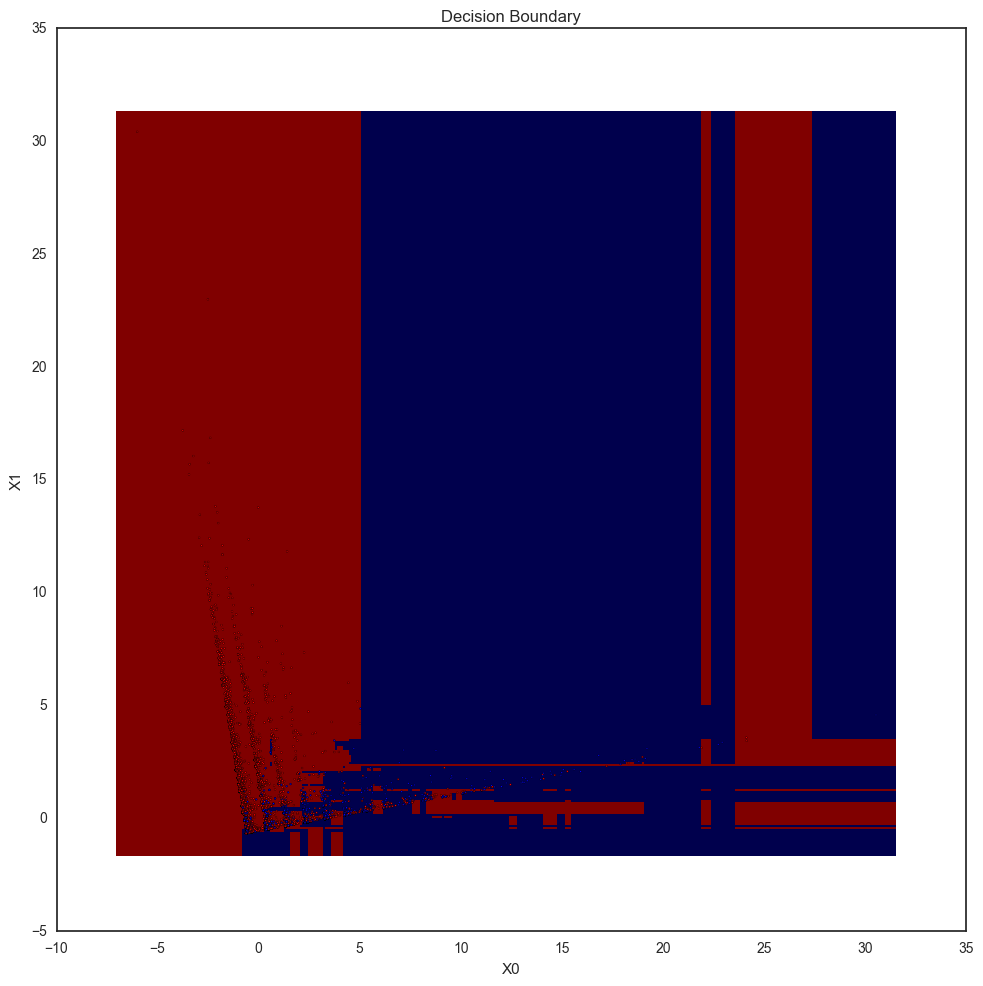

In [39]:
plot_decision_bounderies(None,X_r)

#### with rotation

AUC: 0.677713747982


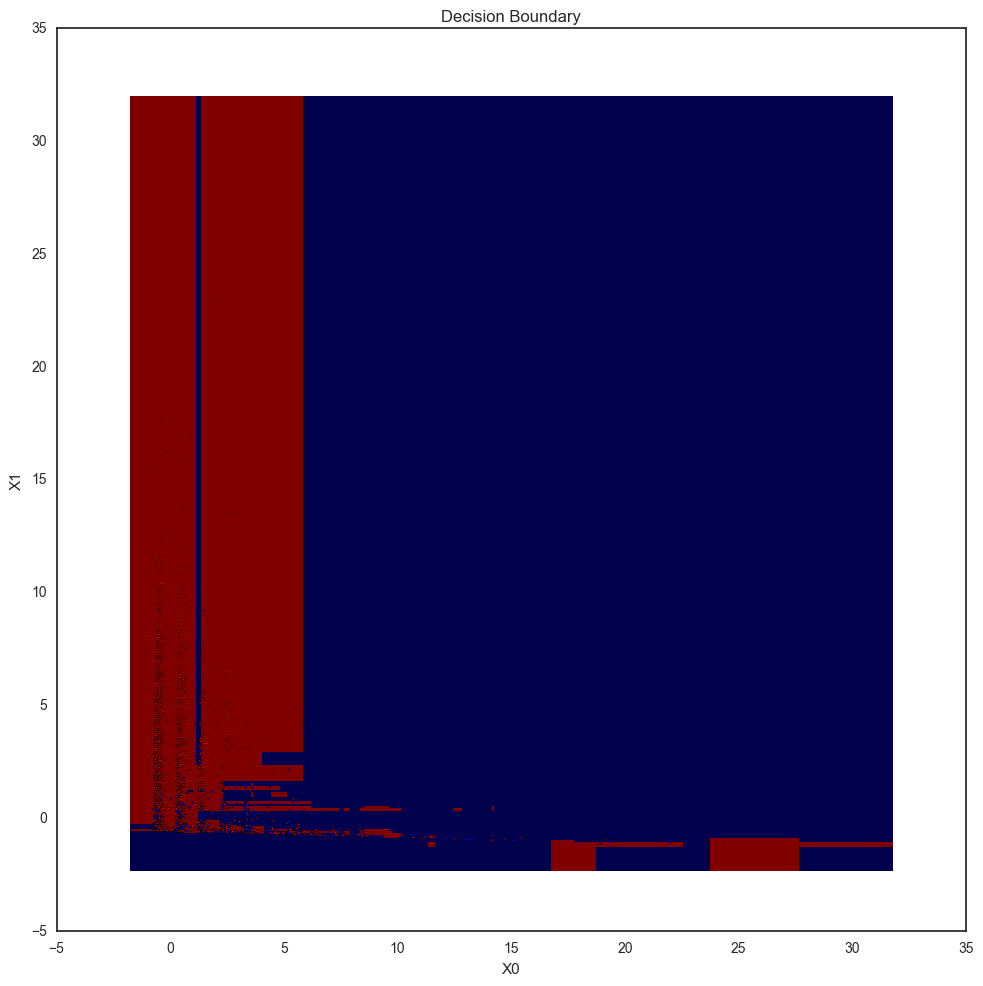

In [40]:
plot_decision_bounderies(None,X_r2)

** Again the rotation gives better AUC!**

## summary 
Here is a summary of all the models we used:

In [41]:
DictTable(d)

Model,AUC
MLP,0.783472580686
Normlized MLP,0.782256338774
Boosting Decision Trees,0.777438926709
KNN,0.771593201492
Gaussian Naive Bayes,0.763251358373
Boosting Gaussian Naive Bayes,0.760883405731


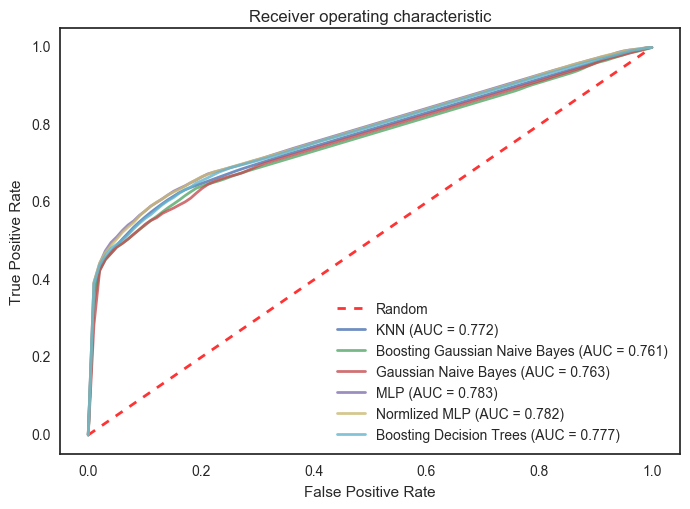

In [42]:
mean_fpr = np.linspace(0, 1, 100)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random', alpha=.8)
for key in d_roc:
    plt.plot(mean_fpr, d_roc[key],
         label=r'%s (AUC = %0.3f)' % (key, d[key]),
         lw=2, alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()